In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv('/content/drive/MyDrive/Speciale/final_stock_sentiment_dataset3.csv')
df['date'] = pd.to_datetime(df['date'])

# --- Define features and target ---
numeric_features = [
    "no_positive_consensus",
    "no_neutral_consensus",
    "no_negative_consensus",
    "like_score_positive",
    "like_score_negative",
    "avg_num_comments",
    "number_of_mentions",
    "no_positive_consensus_general",
    "no_neutral_consensus_general",
    "no_negative_consensus_general",
    "closing_price"
]
target_col = "target"

# --- Filter date ranges ---
train_df = df[(df['date'] >= '2024-04-01') & (df['date'] <= '2024-12-31')]
test_df = df[(df['date'] >= '2025-01-01') & (df['date'] <= '2025-03-31')]

# --- Scale features ---
scaler = MinMaxScaler()
X_train_raw = scaler.fit_transform(train_df[numeric_features])
y_train_raw = train_df[target_col].values

X_test_raw = scaler.transform(test_df[numeric_features])
y_test_raw = test_df[target_col].values

# --- Create rolling sequences ---
def create_sequences(X, y, window=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

# --- Try different sequence lengths ---
results = []

for window in range(3, 8):  # Try 3 to 7 day sequences

    print(f"\n🔄 Training with sequence length = {window}")

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, window)
    X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, window)

    # Train/val split
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train_seq, y_train_seq, test_size=0.2, shuffle=False, random_state=42
    )

    # Build model
    model = Sequential()
    model.add(LSTM(64, input_shape=(window, X_train_final.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        epochs=15,
        batch_size=16,
        verbose=0
    )

    # Evaluate
    val_pred = model.predict(X_val_final).flatten()
    val_pred_class = (val_pred > 0.5).astype(int)
    val_acc = accuracy_score(y_val_final, val_pred_class)
    val_loss = history.history['val_loss'][-1]

    print(f"✅ Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
    results.append((window, val_acc, val_loss))

# --- Print summary ---
results.sort(key=lambda x: x[1], reverse=True)
print("\n🏆 Best sequence lengths:")
print(f"{'Window':<10}{'Val Accuracy':<15}{'Val Loss'}")
for window, acc, loss in results:
    print(f"{window:<10}{acc:<15.4f}{loss:.4f}")



🔄 Training with sequence length = 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Val Accuracy: 0.5227, Val Loss: 0.6941

🔄 Training with sequence length = 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Val Accuracy: 0.5147, Val Loss: 0.6922

🔄 Training with sequence length = 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Val Accuracy: 0.5175, Val Loss: 0.6919

🔄 Training with sequence length = 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Val Accuracy: 0.5203, Val Loss: 0.6919

🔄 Training with sequence length = 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Val Accuracy: 0.5134, Val Loss: 0.6913

🏆 Best sequence lengths:
Window    Val Accuracy   Val Loss
3         0.5227         0.6941
6         0.5203         0.6919
5         0.5175         0.6919
4         0.5147         0.6922
7         0.5134         0.6913


In [2]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,044 (152.52 KB)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


869/869 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5010 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 2/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5111 - loss: 0.6932 - val_accuracy: 0.5104 - val_loss: 0.6929
Epoch 3/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5144 - loss: 0.6923 - val_accuracy: 0.5147 - val_loss: 0.6927
Epoch 4/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5184 - loss: 0.6925 - val_accuracy: 0.5224 - val_loss: 0.6914
Epoch 5/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5196 - loss: 0.6916 - val_accuracy: 0.5175 - val_loss: 0.6923
Epoch 6/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5196 - loss: 0.6912 - val_accuracy: 0.5279 - val_loss: 0.6913
Epoch 7/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5102 - loss: 0.6908 - val_accuracy: 0.5095 - val_loss: 0.6924
Epoch 8/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5244 - loss: 0.6894 - val_accuracy: 0.5270 - val_

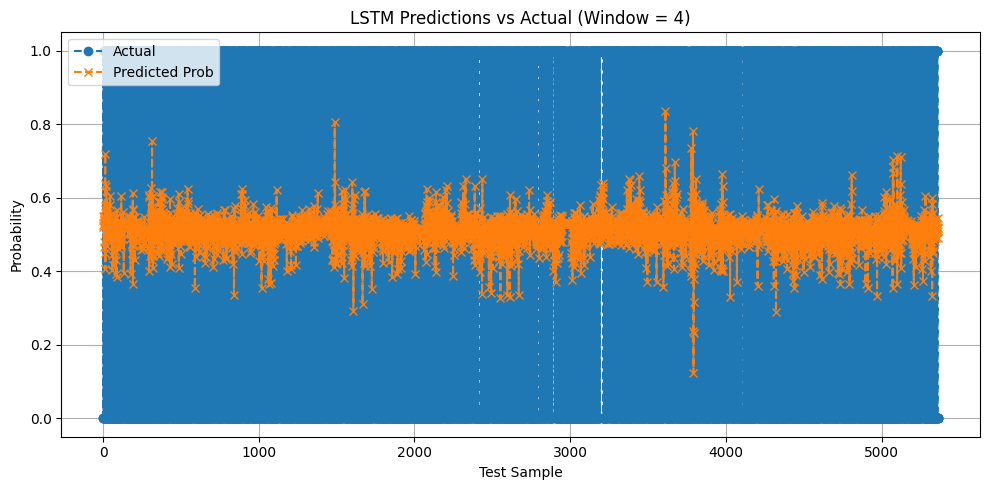

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# --- Set the best sequence length manually (from tuning) ---
best_window = 4

# --- Recreate sequences using best window ---
def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, best_window)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, best_window)

# --- Build and train model on full training set ---
model = Sequential()
model.add(LSTM(64, input_shape=(best_window, X_train_seq.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    verbose=1
)

# --- Predict on test set ---
y_pred_prob = model.predict(X_test_seq).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# --- Evaluate model ---
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test_seq, y_pred)
print(f"{'':<12}{'Predicted 0':<15}{'Predicted 1'}")
print(f"{'Actual 0':<12}{cm[0, 0]:<15}{cm[0, 1]}")
print(f"{'Actual 1':<12}{cm[1, 0]:<15}{cm[1, 1]}\n")

accuracy = accuracy_score(y_test_seq, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

print("Classification Report:\n")
print(classification_report(y_test_seq, y_pred, digits=2))

# --- Plot predicted probabilities vs actual labels ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq, label="Actual", linestyle="--", marker="o")
plt.plot(y_pred_prob, label="Predicted Prob", linestyle="--", marker="x")
plt.title(f"LSTM Predictions vs Actual (Window = {best_window})")
plt.xlabel("Test Sample")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


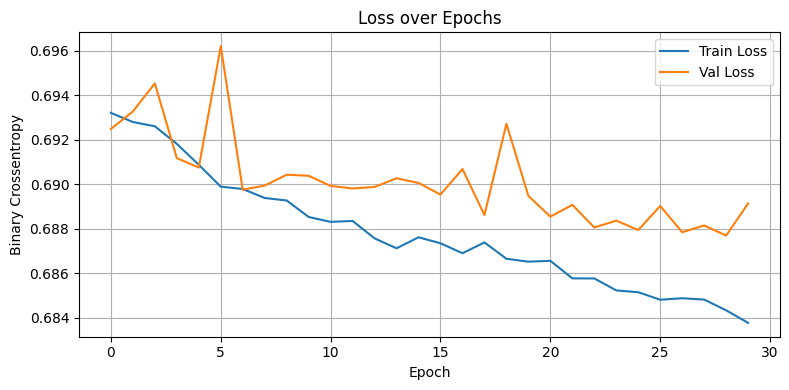

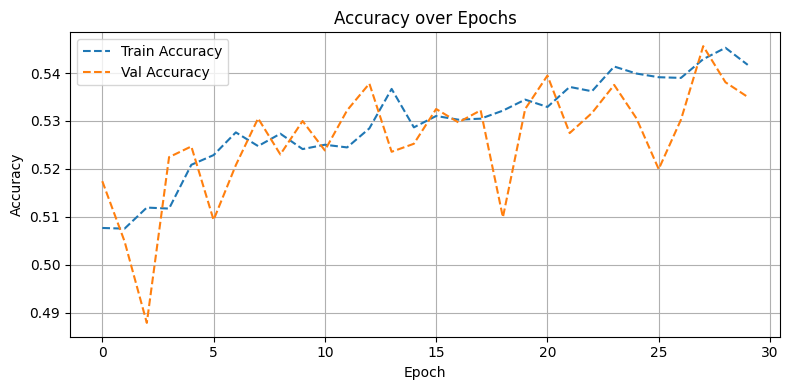

In [ ]:
import matplotlib.pyplot as plt

# --- Plot 1: Loss over Epochs ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', linestyle='-')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss', linestyle='-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Accuracy over Epochs ---
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy', linestyle='--')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# --- Step 1: Add ticker column to test_df sequence-matched rows ---
# You must drop the first `window` rows in test_df to align with sequences
window = 3
test_df_trimmed = test_df.copy().reset_index(drop=True)
test_df_trimmed = test_df_trimmed.iloc[-len(y_test_seq):].reset_index(drop=True)

# Sanity check:
assert len(test_df_trimmed) == len(y_test_seq), "Mismatch in aligned test set lengths"

# --- Step 2: Sum mentions by ticker and get top 10 ---
top_tickers = test_df_trimmed.groupby('ticker')['number_of_mentions'].sum().nlargest(10).index.tolist()

# --- Step 3: Loop through top tickers and compute confusion matrices ---
print("Confusion Matrices for Top 10 Most Mentioned Tickers:\n")

for ticker in top_tickers:
    mask = test_df_trimmed['ticker'] == ticker
    if mask.sum() == 0:
        continue  # skip if no data (edge case)

    y_true = y_test_seq[mask]
    y_pred_ticker = y_pred[mask]

    cm = confusion_matrix(y_true, y_pred_ticker)
    print(f"Ticker: {ticker}")
    print(f"{'':<12}{'Predicted 0':<15}{'Predicted 1'}")
    print(f"{'Actual 0':<12}{cm[0, 0]:<15}{cm[0, 1]}")
    print(f"{'Actual 1':<12}{cm[1, 0]:<15}{cm[1, 1]}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred_ticker, digits=2))
    print("-" * 50)


Confusion Matrices for Top 10 Most Mentioned Tickers:

Ticker: NVDA
            Predicted 0    Predicted 1
Actual 0    11             22
Actual 1    15             15

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.33      0.37        33
           1       0.41      0.50      0.45        30

    accuracy                           0.41        63
   macro avg       0.41      0.42      0.41        63
weighted avg       0.41      0.41      0.41        63

--------------------------------------------------
Ticker: TSLA
            Predicted 0    Predicted 1
Actual 0    9              30
Actual 1    9              15

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.23      0.32        39
           1       0.33      0.62      0.43        24

    accuracy                           0.38        63
   macro avg       0.42      0.43      0.38        63
weighted avg       0.44

In [5]:
import pandas as pd

# Step 1: Load the comparison CSV from classical models
comparison_df = pd.read_csv('/content/drive/MyDrive/Speciale/model_predictions_comparison.csv')  # Adjust path if needed
comparison_df['date'] = pd.to_datetime(comparison_df['date'])

# Step 2: Extract corresponding dates and tickers from test_df for LSTM predictions
# Because LSTM sequences skip the first N rows (equal to best_window), we need to align:
lstm_meta = test_df.iloc[best_window:].reset_index(drop=False)
lstm_meta = lstm_meta[["date", "ticker"]].copy()
lstm_meta["LSTM_Pred"] = y_pred  # Add your LSTM predicted labels

# Step 3: Merge with classical model results (on date and ticker)
merged_df = pd.merge(comparison_df, lstm_meta, on=["date", "ticker"], how="left")

# Step 4: Save merged DataFrame with LSTM predictions
merged_df.to_csv("/content/drive/MyDrive/Speciale/model_predictions_with_lstm.csv", index=False)

# Optional: Show confirmation
print("✅ CSV with LSTM predictions saved as 'model_predictions_with_lstm.csv'")


✅ CSV with LSTM predictions saved as 'model_predictions_with_lstm.csv'
